In [55]:
import numpy as np
import pandas as pd

import math
import re

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Part 1: Pre-processing the dataset

### 1.1. Accessing the dataset and creating a new column for labels

In [56]:
album_df = pd.read_csv('iron_maiden_lyrics.csv')
album_df['label'] = album_df.apply(lambda row: f'{row["album"]} ({row["release_year"]})', 
                                   axis=1)
album_df.head()

,song_title,album,release_year,lyrics,streams,label
0,Prowler,Iron Maiden,1980,Walking through the city\nLooking oh so pretty...,25263021,Iron Maiden (1980)
1,Remember Tomorrow,Iron Maiden,1980,"Unchain the colours, before my eyes\nYesterday...",9743239,Iron Maiden (1980)
2,Running Free,Iron Maiden,1980,"Just sixteen, a pickup truck\nOut of money, ou...",25923993,Iron Maiden (1980)
3,Phantom Of The Opera,Iron Maiden,1980,I've been looking so long for you now\nYou won...,51504561,Iron Maiden (1980)
4,Strange World,Iron Maiden,1980,The only place where you can dream\nLiving her...,11676266,Iron Maiden (1980)


### 1.2. Transforming contractions into words

In [57]:
# THIS IS A GPT-4o GENERATED LIST OF CONTRACTIONS (28 DECEMBER 2024)
# Contractions dictionary
CONTRACTIONS = {
    # Not contractions
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "dont": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "isn't": "is not",
    "mightn't": "might not",
    "mustn't": "must not",
    "shan't": "shall not",
    "shouldn't": "should not",
    "wasn't": "was not",
    "weren't": "were not",
    "won't": "will not",
    "wouldn't": "would not",

    # Pronoun contractions
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "we're": "we are",
    "they're": "they are",
    "who's": "who is",
    "what's": "what is",
    "that's": "that is",
    "there's": "there is",
    "here's": "here is",

    # Auxiliary verb contractions
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "we'll": "we will",
    "they'll": "they will",
    "who'll": "who will",
    "what'll": "what will",
    "that'll": "that will",
    "there'll": "there will",
    "here'll": "here will",

    # Would and had contractions
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "it'd": "it would",
    "we'd": "we would",
    "they'd": "they would",
    "who'd": "who would",
    "what'd": "what would",
    "that'd": "that would",
    "there'd": "there would",
    "here'd": "here would",

    # Have contractions
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "who've": "who have",
    "what've": "what have",
    "that've": "that have",
    "there've": "there have",
    "here've": "here have",

    # Miscellaneous
    "let's": "let us",
    "y'all": "you all",
    "o'clock": "of the clock",
    "ma'am": "madam",
    "how's": "how is",
    "when's": "when is",
    "why's": "why is",
    "where's": "where is",

    # Informal/slang contractions
    "gonna": "going to",
    "wanna": "want to",
    "gotta": "got to",
    "ain't": "is not",  # or "are not" depending on context
    "kinda": "kind of",
    "sorta": "sort of",
    "lemme": "let me",
    "gimme": "give me",
    "dunno": "do not know",
    "outta": "out of",
    "lotta": "lot of",
    "woulda": "would have",
    "coulda": "could have",
    "shoulda": "should have",
    "mighta": "might have",
    "musta": "must have"
}

In [58]:
def expand_contractions(lyrics, contractions = CONTRACTIONS):
    for contraction, expanded in contractions.items():
        lyrics = re.sub(rf'\b{re.escape(contraction)}\b', expanded, lyrics)
    return lyrics

### 1.3. Cleaning lyrics and tokenizing

In [59]:
def clean_lyrics(lyrics):
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    lyrics = re.sub(r'\(.*?\)', '', lyrics)
    lyrics = re.sub(r'[^\w\s]', '', lyrics).lower()
    return lyrics

In [60]:
album_df['lyrics'] = album_df['lyrics'].apply(expand_contractions)
album_df['clean_lyrics'] = album_df['lyrics'].apply(clean_lyrics)
album_df['word_tokens'] = album_df['clean_lyrics'].apply(lambda x: x.split())

upd_stopwords = ['oh', 'ow', 'ooh', 'yeah', 'ha']
album_df['word_tokens'] = album_df['word_tokens'].apply(lambda tokens: [w for w in tokens if w not in upd_stopwords])

album_df.head()

,song_title,album,release_year,lyrics,streams,label,clean_lyrics,word_tokens
0,Prowler,Iron Maiden,1980,Walking through the city\nLooking oh so pretty...,25263021,Iron Maiden (1980),walking through the city\nlooking oh so pretty...,"[walking, through, the, city, looking, so, pre..."
1,Remember Tomorrow,Iron Maiden,1980,"Unchain the colours, before my eyes\nYesterday...",9743239,Iron Maiden (1980),unchain the colours before my eyes\nyesterdays...,"[unchain, the, colours, before, my, eyes, yest..."
2,Running Free,Iron Maiden,1980,"Just sixteen, a pickup truck\nOut of money, ou...",25923993,Iron Maiden (1980),just sixteen a pickup truck\nout of money out ...,"[just, sixteen, a, pickup, truck, out, of, mon..."
3,Phantom Of The Opera,Iron Maiden,1980,I have been looking so long for you now\nYou w...,51504561,Iron Maiden (1980),i have been looking so long for you now\nyou w...,"[i, have, been, looking, so, long, for, you, n..."
4,Strange World,Iron Maiden,1980,The only place where you can dream\nLiving her...,11676266,Iron Maiden (1980),the only place where you can dream\nliving her...,"[the, only, place, where, you, can, dream, liv..."


### 1.4. Calculating Useful Information

In [61]:
def count_repeated_lines(lyrics_text):
    lines = [l.strip() for l in lyrics_text.split('\n') if l.strip()]
    line_counts = Counter(lines)
    
    repeated_line_count = sum(1 for count in line_counts.values() if count > 1)
    total_repeats = sum((count - 1) for count in line_counts.values() if count > 1)
    
    return repeated_line_count, total_repeats

def calculate_words(lyrics):
    words = lyrics.split()
    unique_words = set(words)
    return len(unique_words), len(words)

In [62]:
album_df['unique_words'], album_df['total_words'] = zip(*album_df['lyrics'].apply(calculate_words))
album_df['repeated_line_count'], album_df['total_repeats'] = zip(*album_df['clean_lyrics'].apply(count_repeated_lines))
album_df.head()

,song_title,album,release_year,lyrics,streams,label,clean_lyrics,word_tokens,unique_words,total_words,repeated_line_count,total_repeats
0,Prowler,Iron Maiden,1980,Walking through the city\nLooking oh so pretty...,25263021,Iron Maiden (1980),walking through the city\nlooking oh so pretty...,"[walking, through, the, city, looking, so, pre...",60,186,13,16
1,Remember Tomorrow,Iron Maiden,1980,"Unchain the colours, before my eyes\nYesterday...",9743239,Iron Maiden (1980),unchain the colours before my eyes\nyesterdays...,"[unchain, the, colours, before, my, eyes, yest...",51,84,3,3
2,Running Free,Iron Maiden,1980,"Just sixteen, a pickup truck\nOut of money, ou...",25923993,Iron Maiden (1980),just sixteen a pickup truck\nout of money out ...,"[just, sixteen, a, pickup, truck, out, of, mon...",82,240,4,16
3,Phantom Of The Opera,Iron Maiden,1980,I have been looking so long for you now\nYou w...,51504561,Iron Maiden (1980),i have been looking so long for you now\nyou w...,"[i, have, been, looking, so, long, for, you, n...",113,203,0,0
4,Strange World,Iron Maiden,1980,The only place where you can dream\nLiving her...,11676266,Iron Maiden (1980),the only place where you can dream\nliving her...,"[the, only, place, where, you, can, dream, liv...",85,112,0,0


# Part 2: Shannonian Entropy

### 2.1. Calculating Shannonian Entropy for Every Song

In [63]:
def calculate_entropy(tokens):
    token_count = Counter(tokens)
    total_tokens = len(tokens)
    
    word_probability = [count / total_tokens for count in token_count.values()]
    word_entropy = -sum(p * math.log2(p) for p in word_probability if p > 0)
    
    return word_entropy

In [64]:
album_df['word_entropy'] = album_df['word_tokens'].apply(calculate_entropy)
album_df.head()

,song_title,album,release_year,lyrics,streams,label,clean_lyrics,word_tokens,unique_words,total_words,repeated_line_count,total_repeats,word_entropy
0,Prowler,Iron Maiden,1980,Walking through the city\nLooking oh so pretty...,25263021,Iron Maiden (1980),walking through the city\nlooking oh so pretty...,"[walking, through, the, city, looking, so, pre...",60,186,13,16,5.496954
1,Remember Tomorrow,Iron Maiden,1980,"Unchain the colours, before my eyes\nYesterday...",9743239,Iron Maiden (1980),unchain the colours before my eyes\nyesterdays...,"[unchain, the, colours, before, my, eyes, yest...",51,84,3,3,5.207327
2,Running Free,Iron Maiden,1980,"Just sixteen, a pickup truck\nOut of money, ou...",25923993,Iron Maiden (1980),just sixteen a pickup truck\nout of money out ...,"[just, sixteen, a, pickup, truck, out, of, mon...",82,240,4,16,4.580853
3,Phantom Of The Opera,Iron Maiden,1980,I have been looking so long for you now\nYou w...,51504561,Iron Maiden (1980),i have been looking so long for you now\nyou w...,"[i, have, been, looking, so, long, for, you, n...",113,203,0,0,6.144790
4,Strange World,Iron Maiden,1980,The only place where you can dream\nLiving her...,11676266,Iron Maiden (1980),the only place where you can dream\nliving her...,"[the, only, place, where, you, can, dream, liv...",85,112,0,0,6.052229


### 2.2. Mean Entropy per Album

In [65]:
mean_entropy_per_album = (album_df.groupby(['album', 'release_year'])['word_entropy'].mean().reset_index(name='mean_word_entropy').sort_values(by='release_year'))

mean_entropy_per_album

,album,release_year,mean_word_entropy
4,Iron Maiden,1980,5.540950
5,Killers,1981,5.748638
14,The Number of the Beast,1982,6.274642
7,Piece of Mind,1983,5.828498
8,Powerslave,1984,6.030064
11,Somewhere in Time,1986,6.005723
10,Seventh Son of a Seventh Son,1988,5.946505
6,No Prayer for the Dying,1990,5.835107
3,Fear of the Dark,1992,5.807619
15,The X-Factor,1995,6.094999


### 2.2. Top 10 Highest and Lowest Entropy Songs

In [66]:
top_high_entropy = album_df.nlargest(10, 'word_entropy', keep = 'first')
top_low_entropy = album_df.nsmallest(10, 'word_entropy', keep = 'first')
top_streamed_songs = album_df.nlargest(10, 'streams', keep = 'first')

In [67]:
top_high_entropy[['song_title', 'album', 'release_year', 'word_entropy']]

,song_title,album,release_year,word_entropy
156,The Parchment,Senjutsu,2021,7.376650
147,Empire Of The Clouds,The Book of Souls,2015,7.217727
134,The Talisman,The Final Frontier,2010,7.163109
113,Paschendale,Dance of Death,2003,7.138538
38,Rime Of The Ancient Mariner,Powerslave,1984,7.108587
126,The Legacy,A Matter of Life and Death,2006,7.084476
136,When The Wild Wind Blows,The Final Frontier,2010,7.003478
155,Death Of The Celts,Senjutsu,2021,6.982976
140,The Red And The Black,The Book of Souls,2015,6.799858
73,The Apparition,Fear of the Dark,1992,6.799612


In [68]:
top_low_entropy[['song_title', 'album', 'release_year', 'word_entropy']]

,song_title,album,release_year,word_entropy
94,Don't Look To The Eyes Of A Stranger,Virtual XI,1998,4.362345
104,Out Of The Silent Planet,Brave New World,2000,4.455214
2,Running Free,Iron Maiden,1980,4.580853
51,Seventh Son Of A Seventh Son,Seventh Son of a Seventh Son,1988,4.823506
30,Sun And Steel,Piece of Mind,1983,4.995605
45,Deja-vu,Somewhere in Time,1986,5.097591
50,The Evil That Men Do,Seventh Son of a Seventh Son,1988,5.163940
98,Brave New World,Brave New World,2000,5.199746
1,Remember Tomorrow,Iron Maiden,1980,5.207327
63,Bring Your Daughter... To The Slaughter,No Prayer for the Dying,1990,5.228620


In [69]:
top_streamed_songs[['song_title', 'album', 'release_year', 'word_entropy', 'streams']]

,song_title,album,release_year,word_entropy,streams
27,The Trooper,Piece of Mind,1983,6.472701,490767352
20,Run to the Hills,The Number of the Beast,1982,5.723870,398811685
76,Fear Of The Dark,Fear of the Dark,1992,5.465647,356317780
19,The Number Of The Beast,The Number of the Beast,1982,6.685050,256904417
22,Hallowed Be Thy Name,The Number of the Beast,1982,6.673990,183391433
40,Wasted Years,Somewhere in Time,1986,6.199053,168049981
33,2 Minutes To Midnight,Powerslave,1984,6.242196,157988446
32,Aces High,Powerslave,1984,6.207045,125826087
70,Wasting Love,Fear of the Dark,1992,5.625358,103403307
96,The Wicker Man,Brave New World,2000,5.853941,64040439


# Part 3: Entropy and Iron Maiden Songs

### 3.1. Setting colors for consistency

In [70]:
# Colors for plots by album moving forward
# FYI! Google Collab may have a smaller variety of colors!
albums = album_df['label'].unique()
palette = sns.color_palette('deep', len(albums))
color_dict = {album: palette[i] for i, album in enumerate(albums)}

### 3.2. Boxplot for Word Entropy by Album

In [71]:
props = {'marker': 'D',
         'markerfacecolor': 'black',
         'markeredgecolor': 'black',
         'markersize': 6}

C:\Users\diego\AppData\Local\Temp\ipykernel_8200\769774262.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label',


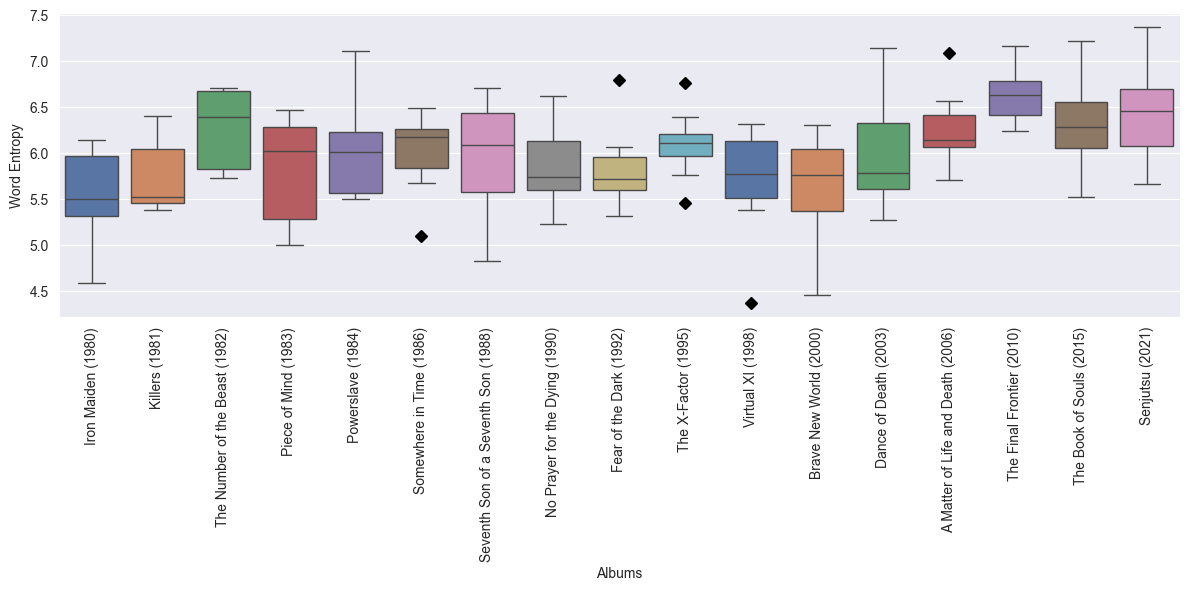

In [72]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', 
            y='word_entropy', 
            data=album_df, 
            palette=color_dict,
            flierprops=props)

plt.xticks(rotation = 90)
plt.tight_layout()
plt.xlabel('Albums')
plt.ylabel('Word Entropy')
plt.show()

### 3.3. Repeated Lines and Correlation with Entropy
I chose not to include this in the final report because it might be too obvious. Results show that the number of repeated lines (usually chorus) is negatively correlated with word entropy values. That said, words that tend to repeat their chorus more often have lower word entropy scores.

In [73]:
correlation_pearson = album_df['word_entropy'].corr(album_df['total_repeats'], 
                                                    method = 'pearson')
correlation_pearson

np.float64(-0.4452642150849521)

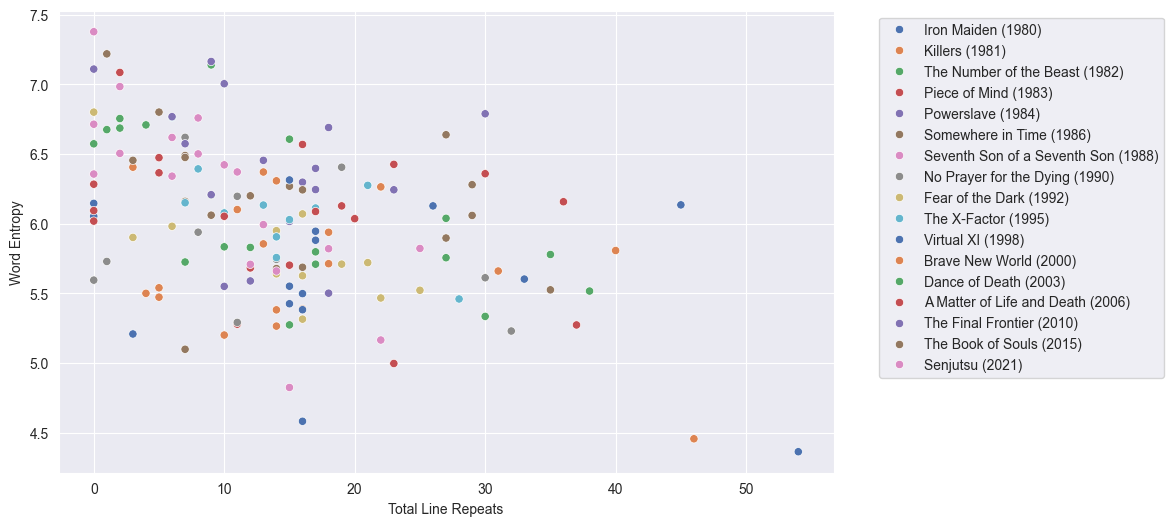

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_repeats', 
                y='word_entropy',
                data=album_df,
                hue='label',
                palette=color_dict)

plt.xlabel('Total Line Repeats')
plt.ylabel('Word Entropy')

plt.legend(bbox_to_anchor=(1.05, 1), 
           loc='upper left')

plt.show()

### 3.4. Brave New World (2000) vs The Final Frontier (2010)
This is an interesting comparison I did not want to include in the final report so it wasn't longer than it needed to be.
After the 90s, Iron Maiden needed a win to go back to the mainstream, which is why I speculate Brave New World has so much repetition in an attempt to go back to their roots. The increased number of repeated lines, and the lower number of unique words is a clear example of it!

In [75]:
album_df['unique_words'], album_df['total_words'] = zip(*album_df['lyrics'].apply(calculate_words))
album_df['repeated_line_count'], album_df['total_repeats'] = zip(*album_df['clean_lyrics'].apply(count_repeated_lines))

subset_df = album_df[album_df['album'].isin(['Brave New World', 'The Final Frontier'])]

subset_albums = subset_df['label'].unique()
subset_palette = {album: color_dict[album] for album in subset_albums}

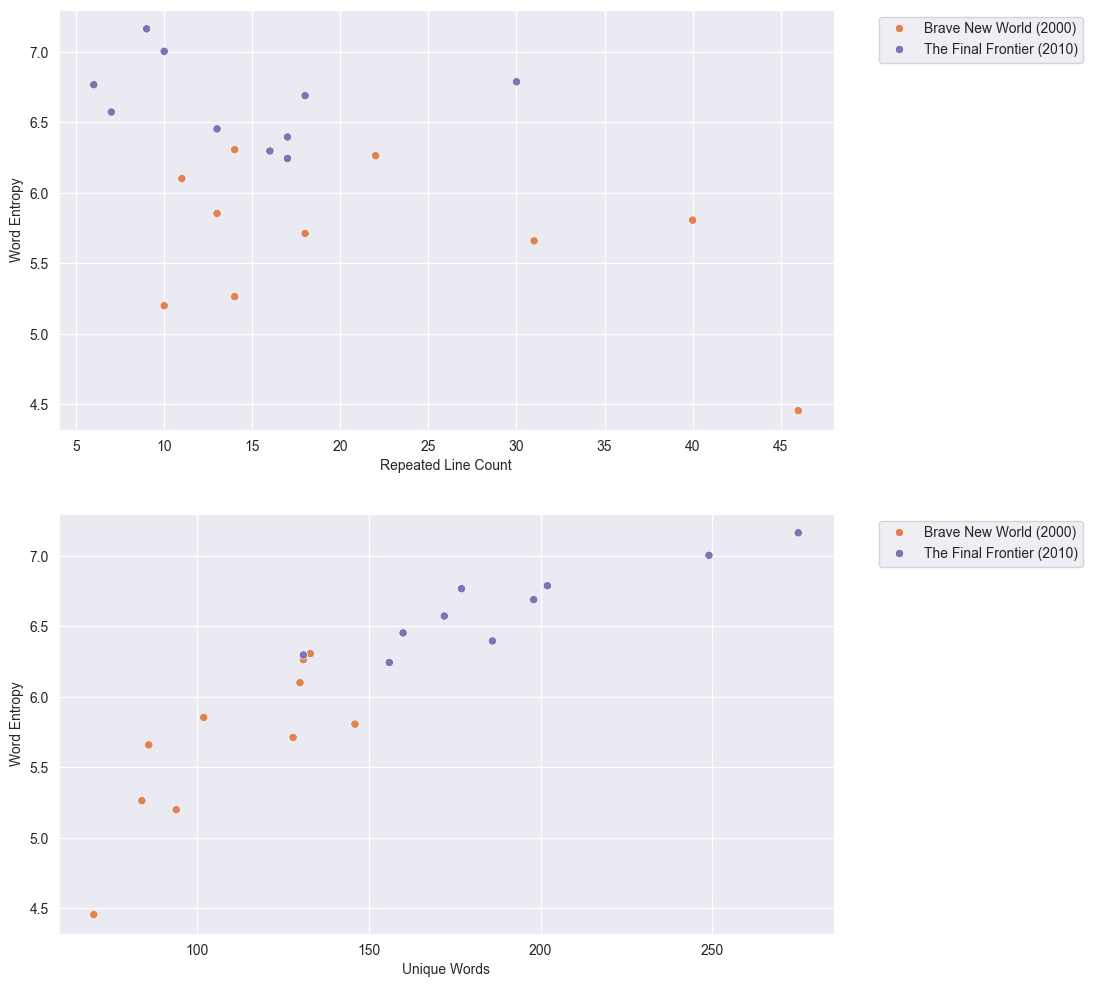

In [76]:
fig, axes = plt.subplots(2, 1, 
                         figsize=(10, 12), 
                         sharex=False)

sns.scatterplot(x='total_repeats',
                y='word_entropy',
                data=subset_df,
                hue='label',
                palette=subset_palette,
                ax=axes[0])

axes[0].set_xlabel('Repeated Line Count')
axes[0].set_ylabel('Word Entropy')
axes[0].legend(bbox_to_anchor=(1.05, 1), 
               loc='upper left', 
               fontsize=10)

sns.scatterplot(x='unique_words',
                y='word_entropy',
                data=subset_df,
                hue='label',
                palette=subset_palette,
                ax=axes[1])

axes[1].set_xlabel('Unique Words')
axes[1].set_ylabel('Word Entropy')
axes[1].legend(bbox_to_anchor=(1.05, 1), 
               loc='upper left', 
               fontsize=10)

plt.show()

# Part 4: Spotify Streams and Entropy

### 4.1. Log transformation for Streams

In [77]:
# log transformations
album_df['log_streams'] = np.log10(album_df['streams'])

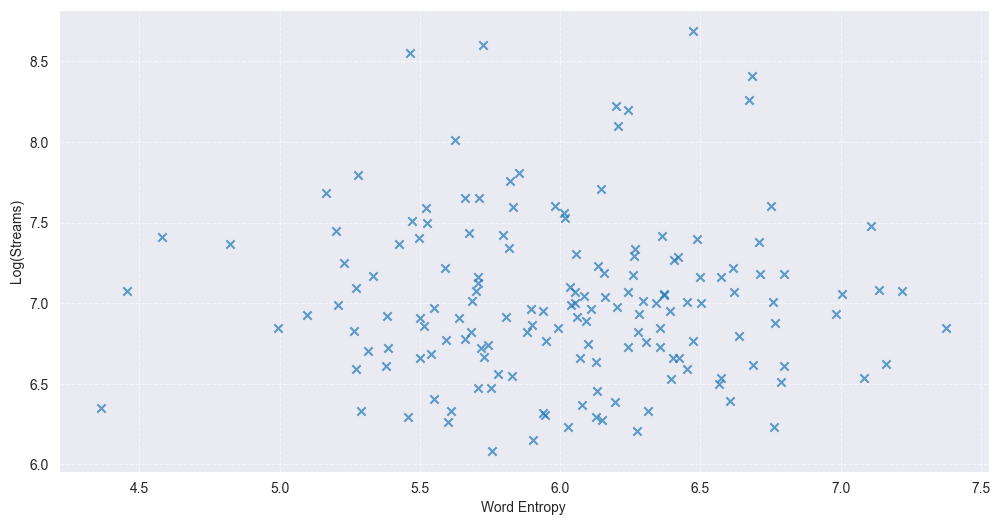

In [78]:
plt.figure(figsize=(12, 6))
plt.scatter(album_df['word_entropy'], 
            album_df['log_streams'], 
            alpha=0.7, 
            marker='x', 
            label='Songs')

plt.xlabel('Word Entropy')
plt.ylabel('Log(Streams)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [79]:
# training and test sets
X = album_df[['word_entropy']]
y = album_df['log_streams']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

# lr
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_predictions)

# quadratic regression (degree=2)
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_predictions = poly_model.predict(X_test_poly)
poly_mse = mean_squared_error(y_test, poly_predictions)

In [80]:
linear_mse, poly_mse

(0.25406609727045215, 0.25443518390584585)

### 4.2. Fitting the lines

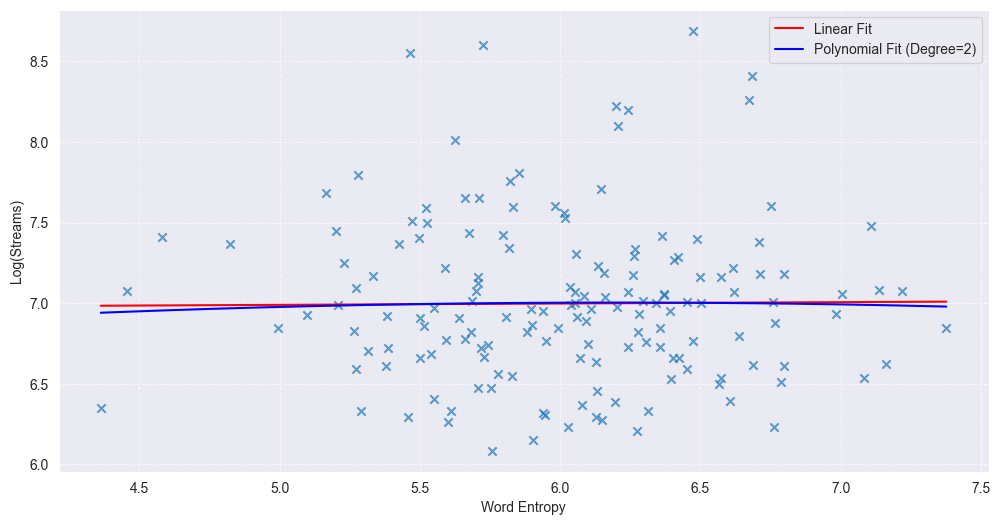

In [81]:
plt.figure(figsize=(12, 6))
plt.scatter(album_df['word_entropy'], 
            album_df['log_streams'], 
            alpha=0.7, 
            marker='x')

x_vals = np.linspace(album_df['word_entropy'].min(), album_df['word_entropy'].max(), 160)
x_vals_df = pd.DataFrame({'word_entropy': x_vals})

# lr line fit
linear_fit = linear_model.predict(x_vals_df)
plt.plot(x_vals, linear_fit, color='red', label='Linear Fit')

# qr line fit
x_vals_poly = poly_features.transform(x_vals_df)
poly_fit = poly_model.predict(x_vals_poly)
plt.plot(x_vals, poly_fit, color='blue', label='Polynomial Fit (Degree=2)')

plt.xlabel('Word Entropy')
plt.ylabel('Log(Streams)')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()